<h1 align="center"> Statistics and Financial Data Analysis </h1>




In [42]:
%reset -f
import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.tsa.stattools as sm_tools

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Predicting AR(1) Coefficients with Regression
===

In [43]:
CiscoRtn = pd.read_csv('CiscoRet.csv', index_col = 0)

In [44]:
CiscoRtn.head()

,CSCO.Close
1,0.025985
2,0.000351
3,0.005604
4,-0.005604
5,0.007349


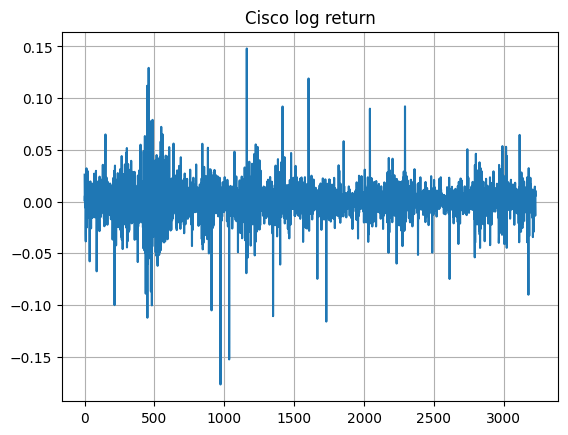

In [45]:
plt.plot(CiscoRtn)
plt.title('Cisco log return')
plt.grid()
plt.show()

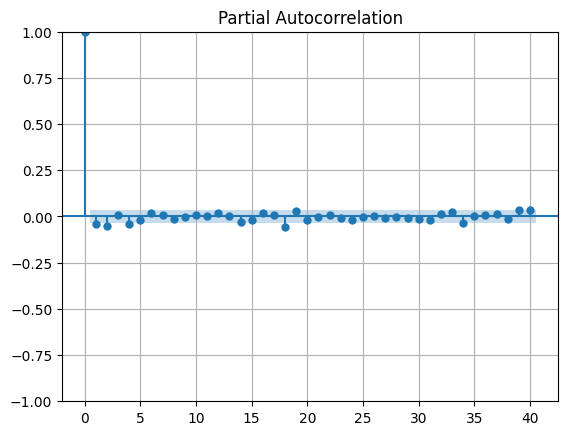

In [46]:
plot_pacf(CiscoRtn,lags=40,zero=True)
plt.grid()
plt.show()

In [47]:
# Fit an AR(1) model to Cisco log returns data

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(CiscoRtn.values, order=(1,0,0)) #Order of AR is 1, MA is 0.
AR1_res = model.fit()
print(AR1_res.summary());


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                8359.147
Date:                Thu, 09 Nov 2023   AIC                         -16712.295
Time:                        16:44:24   BIC                         -16694.057
Sample:                             0   HQIC                        -16705.759
                               - 3227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.527      0.599      -0.000       0.001
ar.L1         -0.0380      0.013     -2.925      0.003      -0.063      -0.013
sigma2         0.0003   3.18e-06    103.419      0.0

A note on 'method': the method can be an input to the 'fit' function. A from the help file:

method : str {'css-mle','mle','css'}
    This is the loglikelihood to maximize.  If "css-mle", the
    conditional sum of squares likelihood is maximized and its values
    are used as starting values for the computation of the exact
    likelihood via the Kalman filter.  If "mle", the exact likelihood
    is maximized via the Kalman Filter.  If "css" the conditional sum
    of squares likelihood is maximized.  All three methods use
    `start_params` as starting parameters.  See above for more
    information.

Excercise: split the data into Y_t = x_t and X_t = x_(t-1) and use a Linear Regression to idetnfiy const/AR parameters: $Y_t = c + \phi_1 X_t + \epsilon$

In [48]:
AR1_res.params

array([ 0.00016462, -0.03801161,  0.00032917])

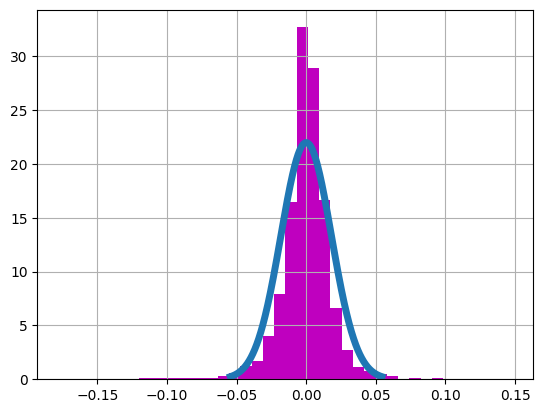

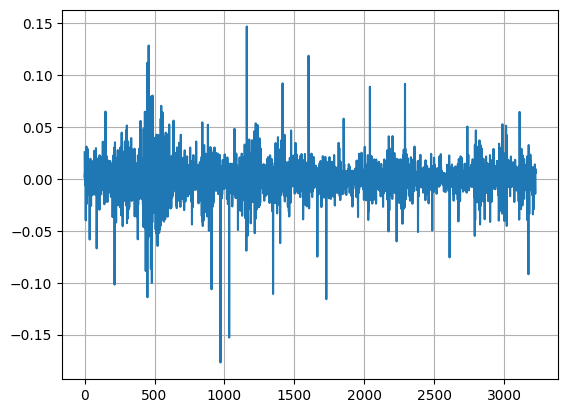

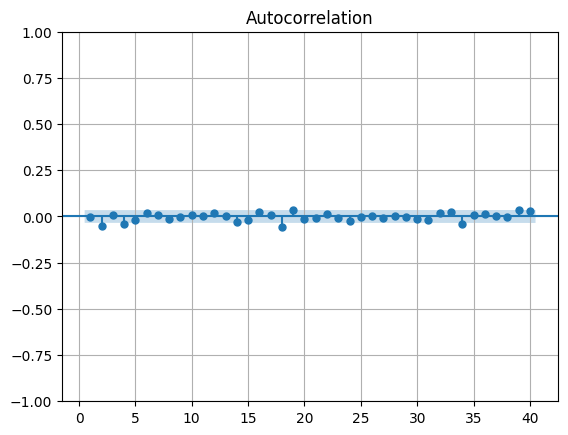

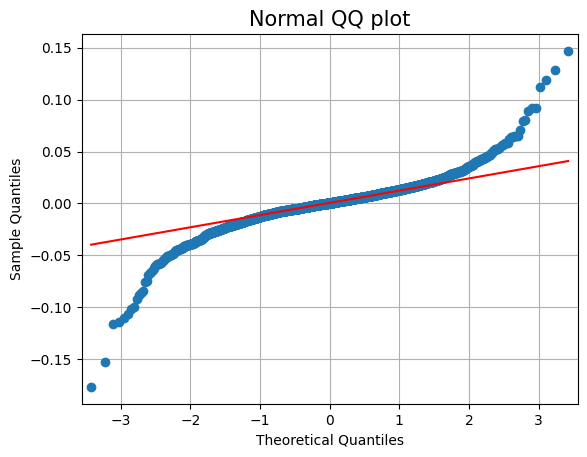

In [49]:
#Returning to AR(1) fitted model and checking for Residual characteristics

resid = AR1_res.resid #residuals
plt.hist(resid, bins =40,color='m', density = True)
mu = resid.mean()
sigma = resid.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()
plt.plot(resid)
plt.grid()
plt.show()
plot_acf(resid,lags=40,zero=False)
plt.grid()
# And not quite normal
fig = sm.qqplot(AR1_res.resid, line='q')
plt.title('Normal QQ plot', fontsize=15)
plt.grid()
plt.show()

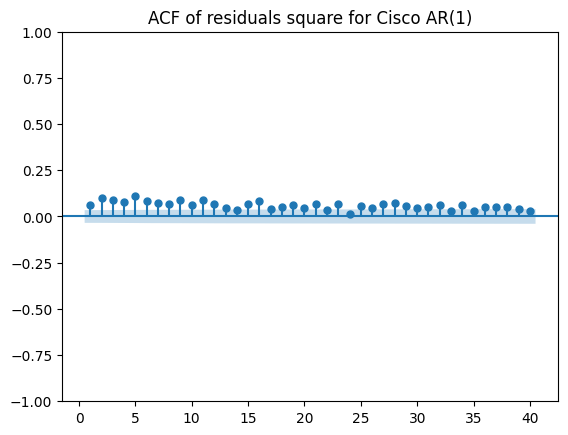

In [50]:
plot_acf(resid**2, lags = 40,zero =False)
plt.title('ACF of residuals square for Cisco AR(1)')
plt.show()

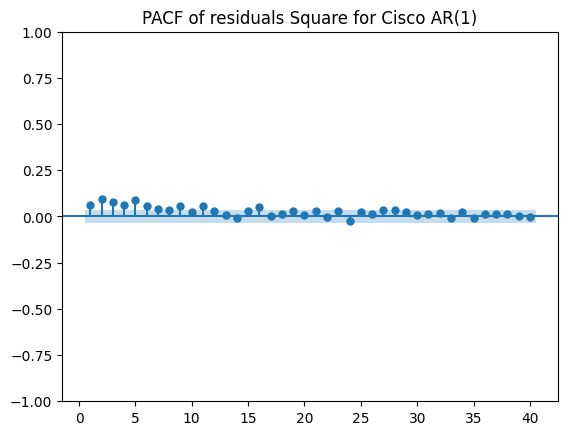

In [51]:
plot_pacf(resid**2, lags = 40,zero =False)
plt.title('PACF of residuals Square for Cisco AR(1)')
plt.show()

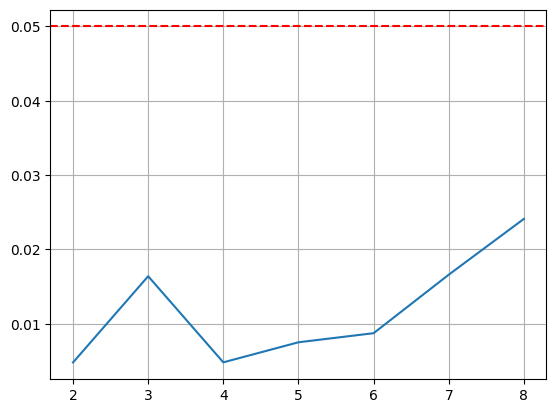

0.016600588216139505

In [52]:
# p-values for terms above 0 of ACF residulas are below 5%

lags = m.floor(np.log(len(resid)))
ljbox_test_res_ciscoAR1 = sm.stats.acorr_ljungbox(resid,lags,model_df=1)
plt.plot(ljbox_test_res_ciscoAR1['lb_pvalue'])
plt.axhline(y=0.05, color='r',ls='--')
plt.grid()
plt.show()
ljbox_test_res_ciscoAR1['lb_pvalue'][7]

In [53]:
ljbox_test_res_ciscoAR1

,lb_stat,lb_pvalue
1,0.011665,NaN
2,7.959858,0.004783
3,8.222040,0.016391
4,12.925618,0.004800
5,13.936271,0.007501
6,15.416200,0.008724
7,15.516150,0.016601
8,16.112112,0.024112


3227
[ 2.86619132e-04 -1.44631833e-04  3.09078394e-04  4.02330880e-04
 -2.06428069e-04  7.73272142e-04  1.63099996e-04 -2.70173562e-04
  1.47784175e-03  1.12223052e-03 -2.35141912e-04 -1.98867085e-04
 -2.85705843e-05  1.28515178e-03 -1.96068329e-04  7.34994718e-04
 -1.65323745e-04  5.89545176e-04 -8.41491337e-05 -1.80059538e-04
 -2.35909150e-05  4.30403403e-04 -3.78498216e-04  4.27619738e-05
  5.72699923e-04  6.91484999e-04 -2.28344873e-04 -4.73173190e-05
  1.72680728e-04  1.64318248e-04  1.64636120e-04  1.64624037e-04
  1.64624496e-04  1.64624479e-04  1.64624479e-04  1.64624479e-04]


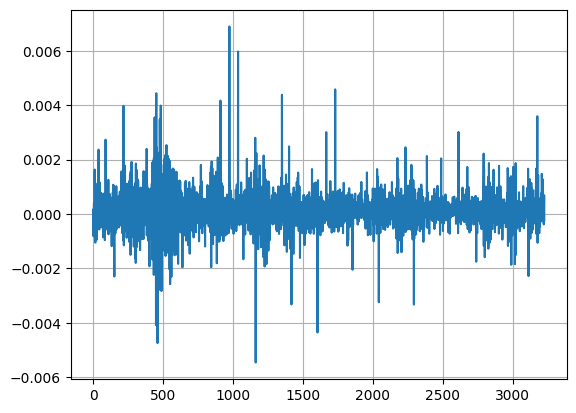

In [54]:
lastIdx = len(AR1_res.fittedvalues)
print(lastIdx)

print(AR1_res.predict(start=3200,end=3235))

#AR1_res.plot_predict(start=3200,end=3235)

plt.plot(AR1_res.predict())
plt.grid()
plt.show()

In [55]:
# You can see that predict for in-sample, just returns fitted values
AR1_res.fittedvalues[3200]

0.0002866191323008513

In [56]:
from statsmodels.tsa.stattools import arma_order_select_ic
best_model = arma_order_select_ic(CiscoRtn.values, max_ar = 6, max_ma =0, ic=['aic', 'bic'])

In [57]:
best_model

{'aic':               0
 0 -16709.626936
 1 -16712.294862
 2 -16718.372401
 3 -16716.602826
 4 -16719.668040
 5 -16718.849702
 6 -16717.724630,
 'bic':               0
 0 -16697.468320
 1 -16694.056937
 2 -16694.055169
 3 -16686.206286
 4 -16683.192191
 5 -16676.294545
 6 -16669.090165,
 'aic_min_order': (4, 0),
 'bic_min_order': (0, 0)}

In [58]:
print('AIC Best: ',best_model.aic_min_order)
print('BIC Best: ',best_model.bic_min_order)

AIC Best:  (4, 0)
BIC Best:  (0, 0)


In [59]:
# Fit an AR(4) model to Cisco log returns data

from statsmodels.tsa.arima.model import ARIMA

model4 = ARIMA(CiscoRtn.values, order=(4,0,0)) #Order of AR is 4, MA is 0.
AR4_res = model4.fit()
print(AR4_res.summary());


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3227
Model:                 ARIMA(4, 0, 0)   Log Likelihood                8365.834
Date:                Thu, 09 Nov 2023   AIC                         -16719.668
Time:                        16:44:38   BIC                         -16683.192
Sample:                             0   HQIC                        -16706.596
                               - 3227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.543      0.587      -0.000       0.001
ar.L1         -0.0392      0.013     -2.952      0.003      -0.065      -0.013
ar.L2         -0.0518      0.012     -4.312      0.0

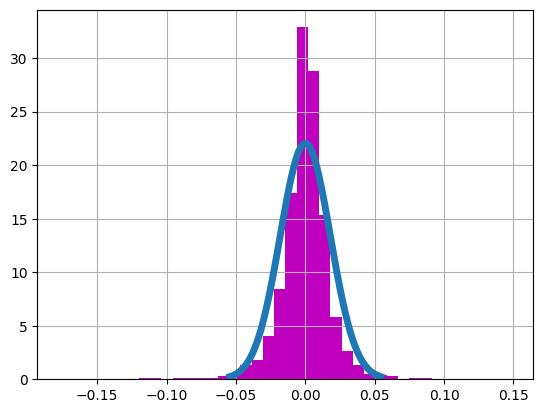

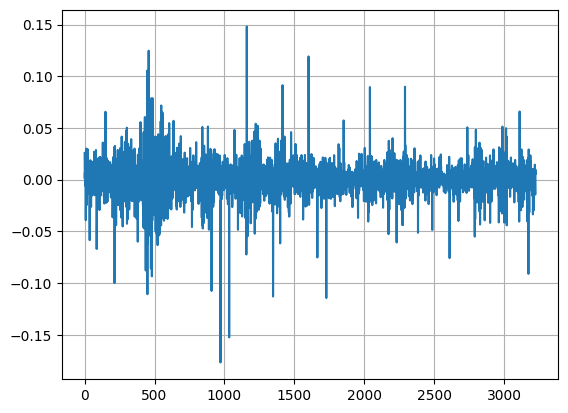

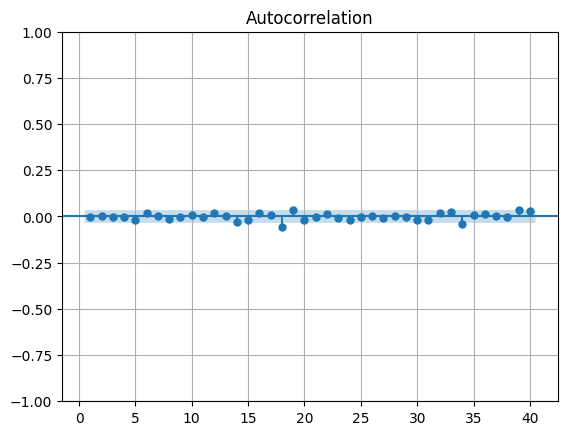

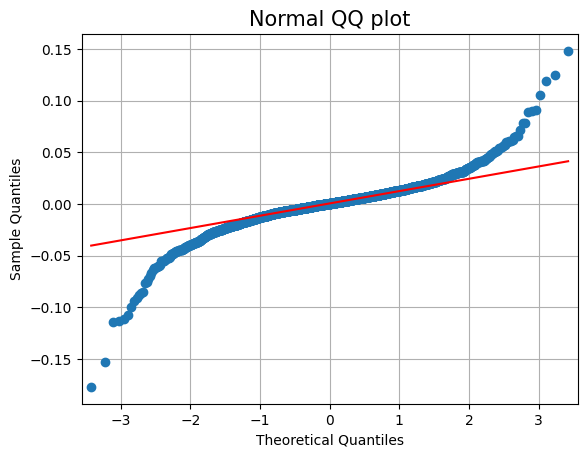

In [60]:
#AR(4) fitted model and checking for Residual characteristics

resid = AR4_res.resid #residuals
plt.hist(resid, bins =40,color='m', density = True)
mu = resid.mean()
sigma = resid.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()
plt.plot(resid)
plt.grid()
plt.show()
plot_acf(resid,lags=40,zero=False)
plt.grid()
# And not quite normal
fig = sm.qqplot(AR4_res.resid, line='q')
plt.title('Normal QQ plot', fontsize=15)
plt.grid()
plt.show()

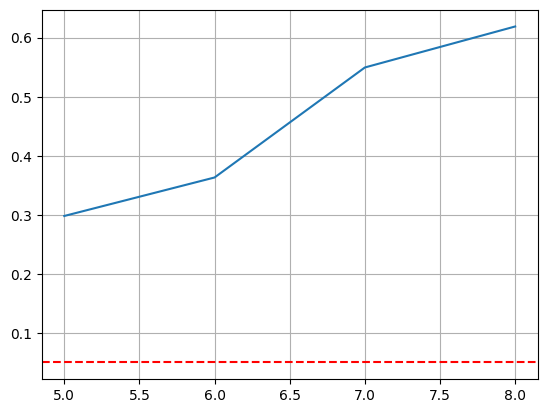

1         NaN
2         NaN
3         NaN
4         NaN
5    0.298059
6    0.363235
7    0.549503
8    0.618922
Name: lb_pvalue, dtype: float64

In [61]:
lags = m.floor(np.log(len(resid)))
ljbox_test_res_ciscoAR1 = sm.stats.acorr_ljungbox(resid,lags,model_df=4)
plt.plot(ljbox_test_res_ciscoAR1['lb_pvalue'])
plt.axhline(y=0.05, color='r',ls='--')
plt.grid()
plt.show()
ljbox_test_res_ciscoAR1['lb_pvalue']

In [62]:
# Selecting other stocks

import pandas_datareader as pd_data
import yfinance as yfin
yfin.pdr_override()
start_date = '2007-01-03'
end_date = '2019-10-28'
QualComData = pd_data.data.get_data_yahoo('QCOM',start_date,end_date)
QualComData.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-21,78.379997,79.089996,78.010002,78.980003,71.987625,5119800
2019-10-22,78.930000,79.070000,78.239998,78.470001,71.522789,4944500
2019-10-23,77.209999,78.129997,76.870003,77.239998,70.401695,5785700
2019-10-24,78.059998,79.019997,77.589996,78.989998,71.996758,5271200
2019-10-25,79.000000,80.230003,78.910004,80.169998,73.072266,6712300


In [63]:
# Log returns
QualComRtn = np.log(QualComData['Close']).diff().dropna() #diff = log(p(t))- log(p(t-1))= log(p(t)/p(t-1)),continuosly compounded return
QualComRtn.head()
len(QualComRtn)


3226

In [64]:
#Fit an AR(1) model to QualCOm log returns data

model = ARIMA(QualComRtn.values, order=(1,0,0)) #Order of AR is 1, MA is 0.
AR1_res_QC = model.fit()
print(AR1_res_QC.summary());



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3226
Model:                 ARIMA(1, 0, 0)   Log Likelihood                8059.866
Date:                Thu, 09 Nov 2023   AIC                         -16113.733
Time:                        16:44:41   BIC                         -16095.496
Sample:                             0   HQIC                        -16107.197
                               - 3226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.678      0.498      -0.000       0.001
ar.L1         -0.0201      0.010     -1.992      0.046      -0.040      -0.000
sigma2         0.0004   3.65e-06    108.463      0.0

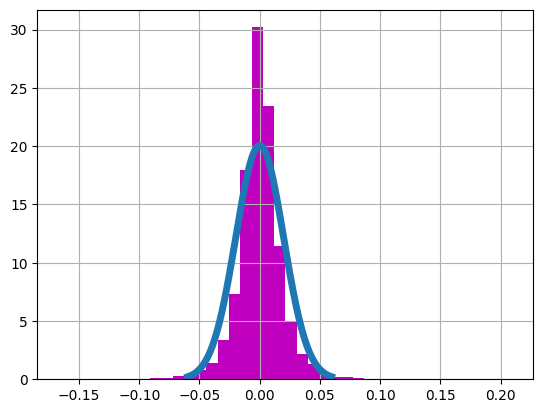

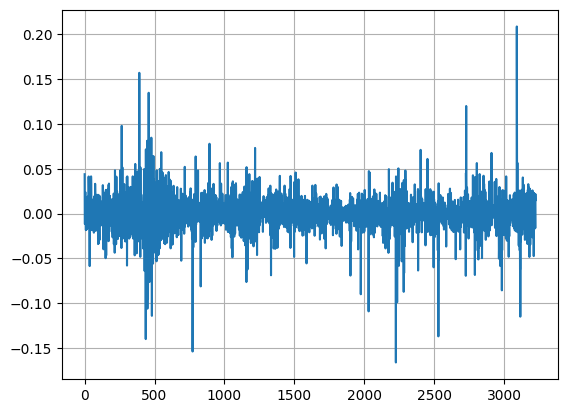

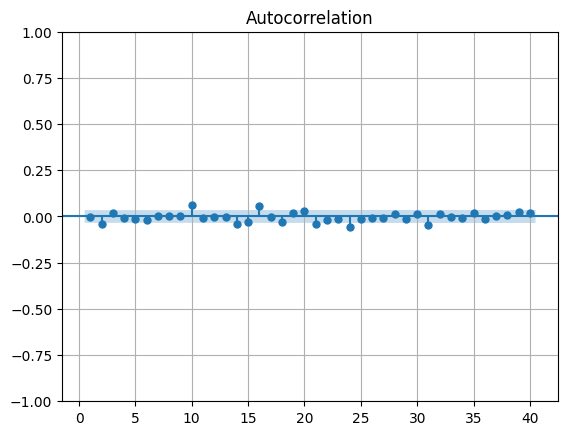

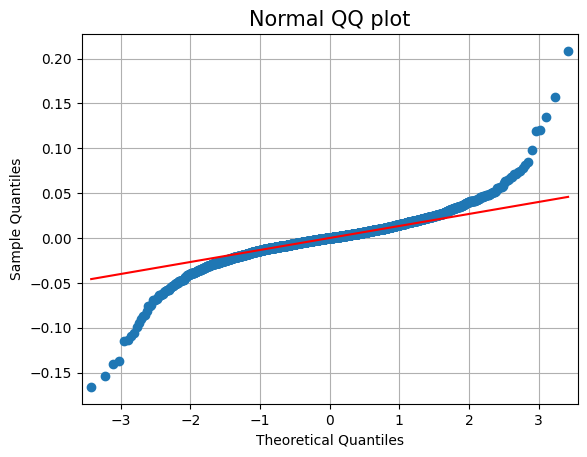

In [65]:
#Returning to AR(1) fitted model and checking for Residual characteristics

resid = AR1_res_QC.resid #residuals
plt.hist(resid, bins =40,color='m', density = True)
mu = resid.mean()
sigma = resid.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()
plt.plot(resid)
plt.grid()
plt.show()
plot_acf(resid,lags=40,zero=False)
plt.grid()
fig = sm.qqplot(AR1_res_QC.resid, line='q')
plt.title('Normal QQ plot', fontsize=15)
plt.grid()
plt.show()

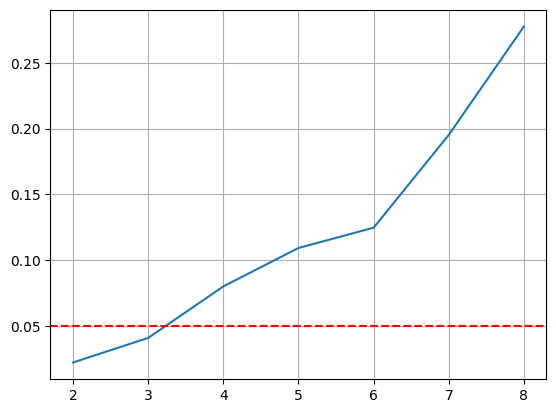

1         NaN
2    0.022193
3    0.040866
4    0.080020
5    0.109236
6    0.124632
7    0.195219
8    0.277629
Name: lb_pvalue, dtype: float64

In [66]:
lags = m.floor(np.log(len(resid)))
ljbox_test_res_QCAR1 = sm.stats.acorr_ljungbox(resid,lags,model_df=1)
plt.plot(ljbox_test_res_QCAR1['lb_pvalue'])
plt.axhline(y=0.05, color='r',ls='--')
plt.grid()
plt.show()
ljbox_test_res_QCAR1['lb_pvalue']

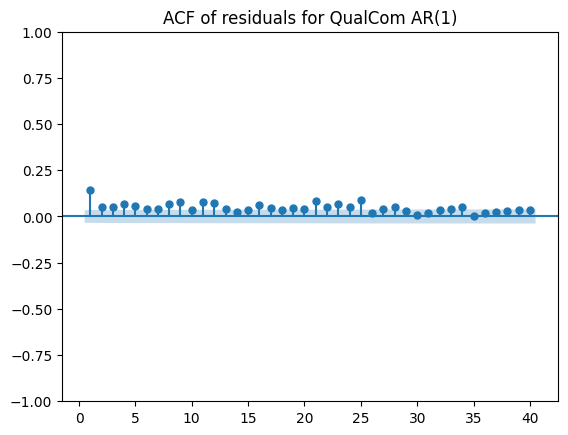

In [67]:
plot_acf(resid**2, lags = 40,zero =False)
plt.title('ACF of residuals for QualCom AR(1)')
plt.show()

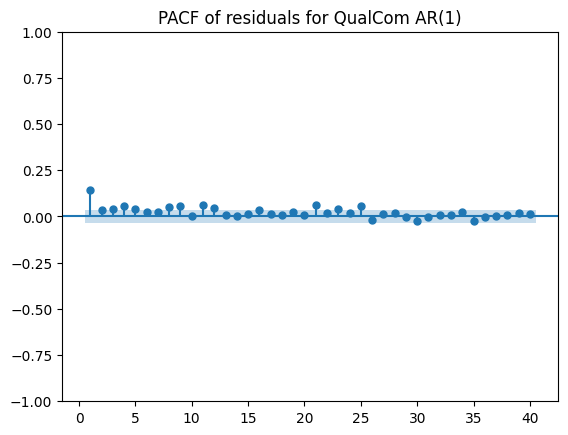

In [68]:
plot_pacf(resid**2, lags = 40,zero =False)
plt.title('PACF of residuals for QualCom AR(1)')
plt.show()

3226


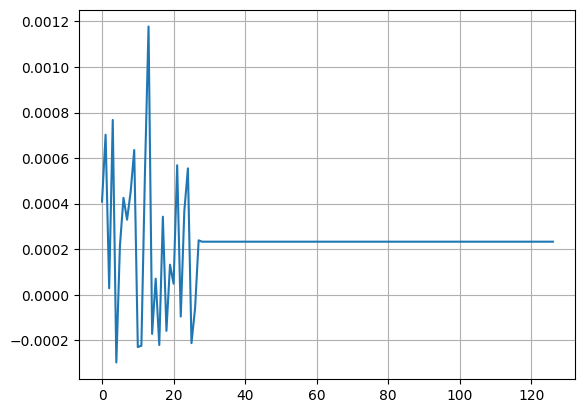

In [69]:
lastIdx = len(AR1_res_QC.fittedvalues)
print(lastIdx)

start_index = lastIdx
end_index = start_index+100

test = AR1_res_QC.predict(start = start_index, end = end_index)
test2 = np.concatenate([AR1_res_QC.fittedvalues[3200:],test])
plt.plot(test2)
plt.grid()
plt.show()


In [70]:
# Retrieving AEMO prices - retail prices of electricity

df3 = pd.read_csv('AEMOPriceDataSimple.csv', index_col = 0)
df3.head()

,RRP
Date,
01/01/13,46.15
02/01/13,47.72
03/01/13,48.08
04/01/13,49.65
05/01/13,51.56


In [71]:
logprice = np.log(df3)
logprice.head()

,RRP
Date,
01/01/13,3.831897
02/01/13,3.865351
03/01/13,3.872866
04/01/13,3.904998
05/01/13,3.942746


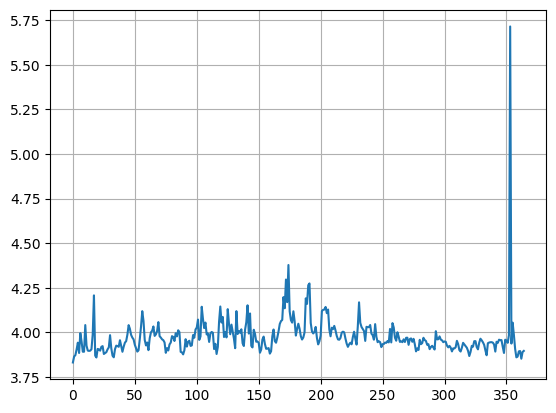

In [72]:
plt.plot(logprice.values)
plt.grid()
plt.show()

In [73]:
percent_replace = 4.266077 # replace with quantile 99%
percent_replace

4.266077

In [74]:
# Do something about outlier (it makes sense in this case)
loc = logprice.idxmax()
logprice['RRP'][loc]=percent_replace

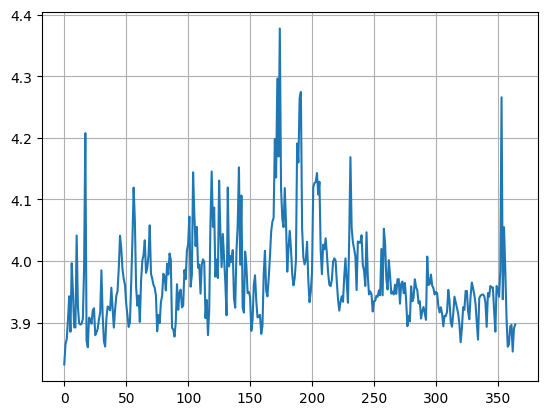

In [75]:
plt.plot(logprice.values)
plt.grid()
plt.show()

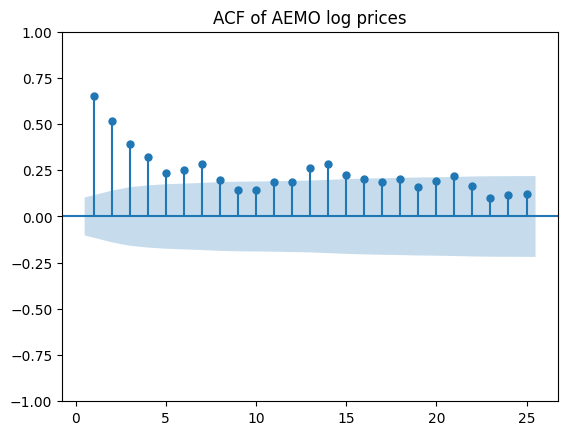

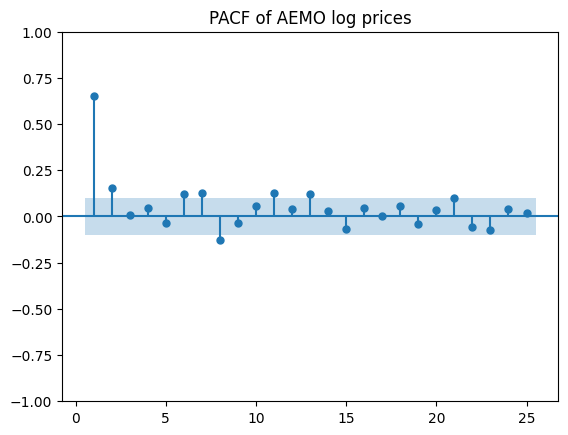

In [76]:
plot_acf(logprice.values, lags = 25, zero=False)
plt.title('ACF of AEMO log prices')
plot_pacf(logprice.values, lags = 25, zero=False)
plt.title('PACF of AEMO log prices')
plt.show()

In [77]:
model3 = ARIMA(logprice.values, order=(1,0,0))
AR1_res_AEMO = model3.fit()
print(AR1_res_AEMO.summary())
AR1_res_AEMO.params

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 524.263
Date:                Thu, 09 Nov 2023   AIC                          -1042.526
Time:                        16:44:45   BIC                          -1030.826
Sample:                             0   HQIC                         -1037.876
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9712      0.011    345.367      0.000       3.949       3.994
ar.L1          0.6592      0.027     24.266      0.000       0.606       0.712
sigma2         0.0033      0.000     23.409      0.0

array([3.97115860e+00, 6.59221406e-01, 3.30509888e-03])

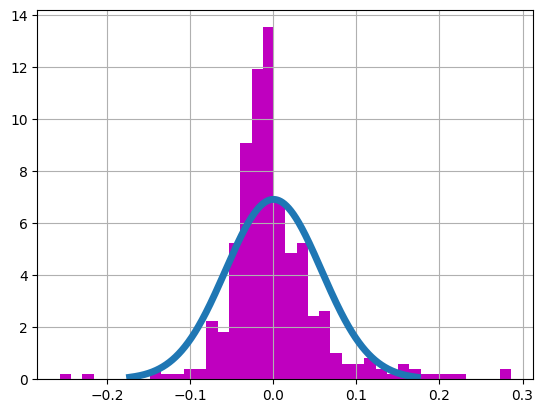

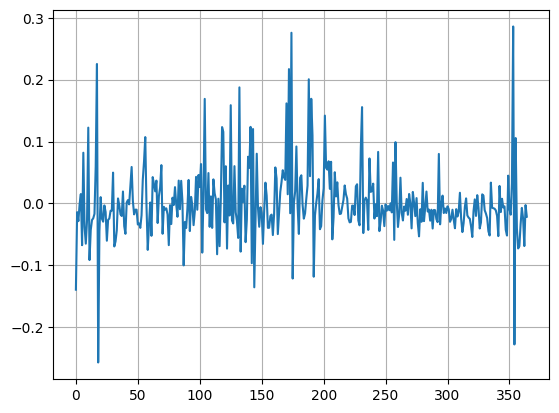

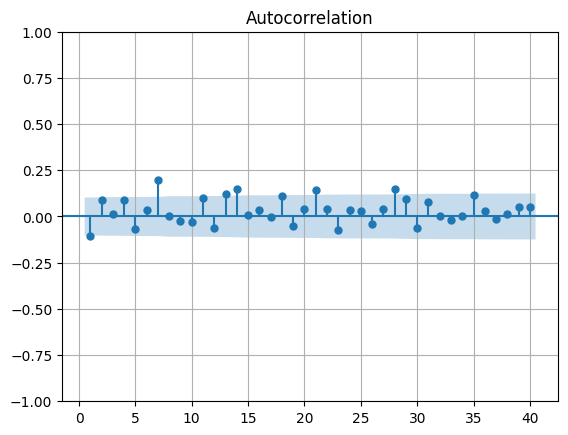

In [78]:
#Returning to AR(1) fitted model and checking for Residual characteristics

resid = AR1_res_AEMO.resid
plt.hist(resid, bins =40,color='m', density = True)
mu = resid.mean()
sigma = resid.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()
plt.plot(resid)
plt.grid()
plt.show()
plot_acf(resid,lags=40,zero=False)
plt.grid()
plt.show()

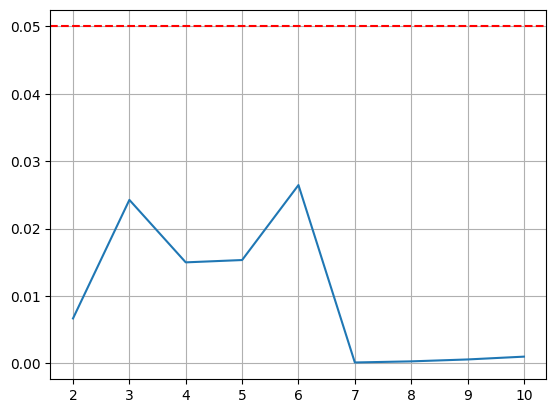

      lb_stat  lb_pvalue
1    4.288804        NaN
2    7.361476   0.006664
3    7.437876   0.024260
4   10.467020   0.014986
5   12.288339   0.015331
6   12.690170   0.026462
7   27.333052   0.000125
8   27.333052   0.000290
9   27.521691   0.000574
10  27.898866   0.000992


1          NaN
2     0.006664
3     0.024260
4     0.014986
5     0.015331
6     0.026462
7     0.000125
8     0.000290
9     0.000574
10    0.000992
Name: lb_pvalue, dtype: float64

In [79]:
# p-values for terms above 0 of ACF residulas are below 5%

lags = m.floor(np.log(len(resid)))
ljbox_test_res_AEMOAR1 = sm.stats.acorr_ljungbox(resid,10,model_df=1)
plt.plot(ljbox_test_res_AEMOAR1['lb_pvalue'])
plt.axhline(y=0.05, color='r',ls='--')
plt.grid()
plt.show()
print(ljbox_test_res_AEMOAR1)
ljbox_test_res_AEMOAR1['lb_pvalue']

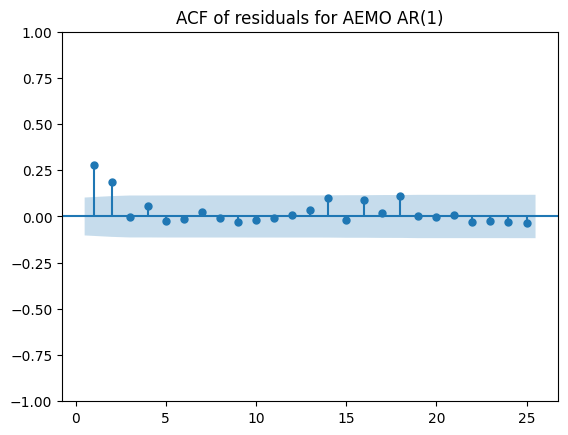

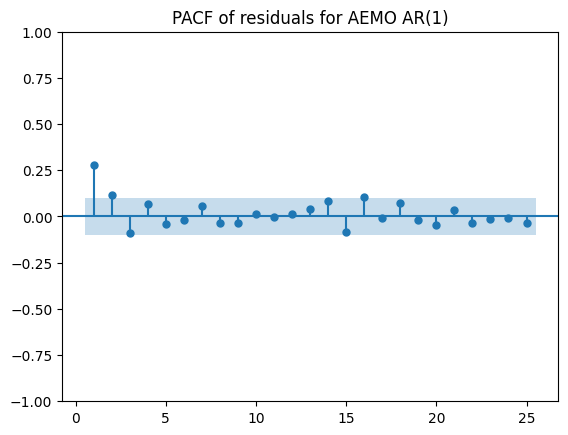

In [80]:
plot_acf(resid**2, lags = 25,zero=False)
plt.title('ACF of residuals for AEMO AR(1)')
plot_pacf(resid**2, lags = 25,zero=False)
plt.title('PACF of residuals for AEMO AR(1)')
plt.show()